# original CNN+LSTM

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_23479/1789792451.py:57: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])


Epoch: 10, Loss: 0.00258
Epoch: 20, Loss: 0.00129
Epoch: 30, Loss: 0.00082
Epoch: 40, Loss: 0.00056
Epoch: 50, Loss: 0.00043
Epoch: 60, Loss: 0.00034
Epoch: 70, Loss: 0.00029
Epoch: 80, Loss: 0.00025
Epoch: 90, Loss: 0.00022
Epoch: 100, Loss: 0.00020
Epoch: 110, Loss: 0.00019
Epoch: 120, Loss: 0.00018
Epoch: 130, Loss: 0.00017
Epoch: 140, Loss: 0.00017
Epoch: 150, Loss: 0.00016
Epoch: 160, Loss: 0.00016
Epoch: 170, Loss: 0.00016
Epoch: 180, Loss: 0.00015
Epoch: 190, Loss: 0.00015
Epoch: 200, Loss: 0.00015
Epoch: 210, Loss: 0.00014
Epoch: 220, Loss: 0.00014
Epoch: 230, Loss: 0.00014
Epoch: 240, Loss: 0.00014
Epoch: 250, Loss: 0.00014
Epoch: 260, Loss: 0.00013
Epoch: 270, Loss: 0.00013
Epoch: 280, Loss: 0.00013
Epoch: 290, Loss: 0.00013
Epoch: 300, Loss: 0.00013
Epoch: 310, Loss: 0.00013
Epoch: 320, Loss: 0.00012
Epoch: 330, Loss: 0.00012
Epoch: 340, Loss: 0.00012
Epoch: 350, Loss: 0.00012
Epoch: 360, Loss: 0.00012
Epoch: 370, Loss: 0.00012
Epoch: 380, Loss: 0.00012
Epoch: 390, Loss: 0.0

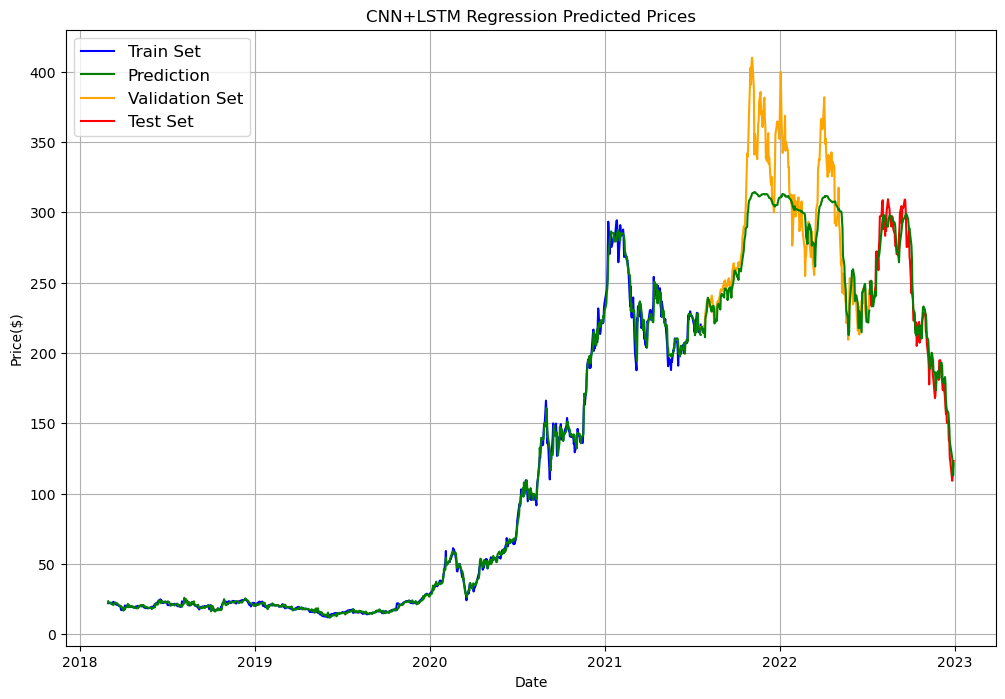

Training completed in 0.67 minutes.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DAYS_FOR_TRAIN = 40  # 用于训练的时间窗口

# 定义CNN+LSTM模型
class CNN_LSTM_Regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=1, cnn_filters=64, kernel_size=3):
        super().__init__()
        # CNN部分: 输入格式为 (seq_len, batch, feature_dim)
        # 我们需要转换为 (batch, feature_dim, seq_len) 后输入CNN
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters),
            nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # LSTM部分
        self.lstm = nn.LSTM(cnn_filters, hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (time_step, batch, feature_dim)
        # 转换为CNN输入格式: (batch, feature_dim, time_step)
        x = x.permute(1, 2, 0)
        x = self.cnn(x)  # CNN输出: (batch, cnn_filters, new_seq_len)
        
        # 转回LSTM需要的格式: (new_seq_len, batch, cnn_filters)
        x = x.permute(2, 0, 1)
        x, _ = self.lstm(x)
        x = x[-1, :, :]
        x = self.fc(x)
        return x

def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x)
        dataset_y.append(close_prices[i + days_for_train])
    return np.array(dataset_x), np.array(dataset_y)

if __name__ == '__main__':
    t0 = time.time()

    # 读取CSV文件并提取特征列
    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    # 数据归一化
    max_features = np.max(data_features, axis=0)
    min_features = np.min(data_features, axis=0)
    data_features = (data_features - min_features) / (max_features - min_features)

    max_close = np.max(close_prices)
    min_close = np.min(close_prices)
    close_prices = (close_prices - min_close) / (max_close - min_close)

    # 创建数据集
    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    train_x = train_x.transpose(1, 0, 2)
    train_y = train_y.reshape(-1, 1)
    val_x = val_x.transpose(1, 0, 2)
    val_y = val_y.reshape(-1)
    test_x = test_x.transpose(1, 0, 2)
    test_y = test_y.reshape(-1)

    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    # 初始化CNN+LSTM模型
    model = CNN_LSTM_Regression(input_size=5, hidden_size=15, output_size=1, num_layers=1, cnn_filters=64, kernel_size=3)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # 模型训练
    for i in range(400):
        model.train()
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 10 == 0:
            print(f'Epoch: {i + 1}, Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).view(-1).data.numpy()
        val_pred = model(val_x).view(-1).data.numpy()
        test_pred = model(test_x).view(-1).data.numpy()

    # 反归一化
    train_pred_real = train_pred * (max_close - min_close) + min_close
    val_pred_real = val_pred * (max_close - min_close) + min_close
    test_pred_real = test_pred * (max_close - min_close) + min_close

    train_y_real = train_y.numpy().flatten() * (max_close - min_close) + min_close
    val_y_real = val_y * (max_close - min_close) + min_close
    test_y_real = test_y * (max_close - min_close) + min_close

    # 将回归预测转换为方向（上涨/下跌）预测
    def get_direction(y):
        return (np.diff(y) > 0).astype(int)

    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    # 计算分类指标
    def print_metrics(name, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"{name} Set Metrics:")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
        print(classification_report(y_true, y_pred, zero_division=0))

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    # 可视化结果
    plt.figure(figsize=(12, 8))
    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('CNN+LSTM Regression Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')
# # 可视化结果，与上一段代码相同的画图输出
# plt.figure(figsize=(12, 8))

# # 绘制训练集的真实值和预测值
# plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
# plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

# # 绘制验证集的真实值和预测值
# plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
# plt.plot(val_dates, val_pred_real, color='green')

# # 绘制测试集的真实值和预测值
# plt.plot(test_dates, test_y_real, label='Test Set', color='red')
# plt.plot(test_dates, test_pred_real, color='green')

# # 图表设置
# plt.title('CNN+LSTM Regression Predicted Prices')
# plt.xlabel('Date')
# plt.ylabel('Price($)')
# plt.legend(fontsize=12)
# plt.grid()
# plt.show()

# # 训练完成时间输出
# t1 = time.time()
# print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')


# Ablation Study Part
- This part uses only LSTM to predict.

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_25610/1956182838.py:37: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])


Epoch: 10, Loss: 0.03581
Epoch: 20, Loss: 0.01023
Epoch: 30, Loss: 0.00612
Epoch: 40, Loss: 0.00390
Epoch: 50, Loss: 0.00174
Epoch: 60, Loss: 0.00061
Epoch: 70, Loss: 0.00046
Epoch: 80, Loss: 0.00038
Epoch: 90, Loss: 0.00032
Epoch: 100, Loss: 0.00029
Epoch: 110, Loss: 0.00028
Epoch: 120, Loss: 0.00027
Epoch: 130, Loss: 0.00026
Epoch: 140, Loss: 0.00026
Epoch: 150, Loss: 0.00025
Epoch: 160, Loss: 0.00025
Epoch: 170, Loss: 0.00025
Epoch: 180, Loss: 0.00024
Epoch: 190, Loss: 0.00024
Epoch: 200, Loss: 0.00024
Epoch: 210, Loss: 0.00023
Epoch: 220, Loss: 0.00023
Epoch: 230, Loss: 0.00023
Epoch: 240, Loss: 0.00022
Epoch: 250, Loss: 0.00022
Epoch: 260, Loss: 0.00022
Epoch: 270, Loss: 0.00021
Epoch: 280, Loss: 0.00021
Epoch: 290, Loss: 0.00029
Epoch: 300, Loss: 0.00022
Epoch: 310, Loss: 0.00021
Epoch: 320, Loss: 0.00021
Epoch: 330, Loss: 0.00020
Epoch: 340, Loss: 0.00020
Epoch: 350, Loss: 0.00020
Epoch: 360, Loss: 0.00019
Epoch: 370, Loss: 0.00019
Epoch: 380, Loss: 0.00019
Epoch: 390, Loss: 0.0

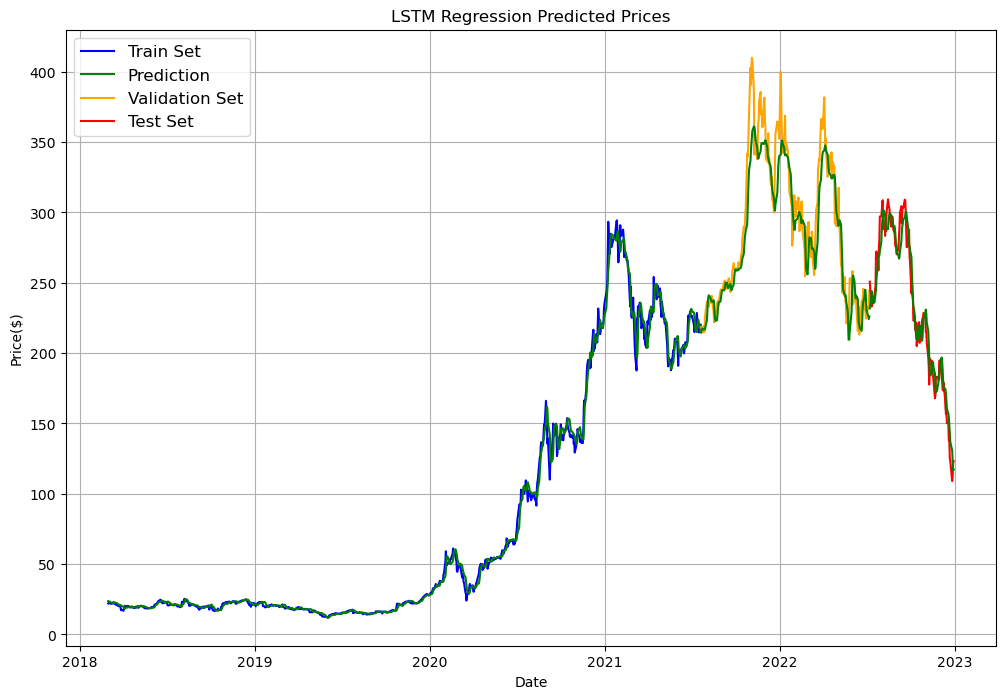

Training completed in 0.36 minutes.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DAYS_FOR_TRAIN = 40  # 用于训练的时间窗口

# 定义LSTM模型（与原始代码一致，无CNN）
class LSTM_Regression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, _x):
        x, _ = self.lstm(_x)
        x = x[-1, :, :]    # 提取最后一个时间步的隐藏状态
        x = self.fc(x)
        return x

def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x)
        dataset_y.append(close_prices[i + days_for_train])
    return np.array(dataset_x), np.array(dataset_y)

if __name__ == '__main__':
    t0 = time.time()

    # 读取CSV文件并提取特征列
    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    # 数据归一化
    max_features = np.max(data_features, axis=0)
    min_features = np.min(data_features, axis=0)
    data_features = (data_features - min_features) / (max_features - min_features)

    max_close = np.max(close_prices)
    min_close = np.min(close_prices)
    close_prices = (close_prices - min_close) / (max_close - min_close)

    # 创建数据集
    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    train_x = train_x.transpose(1, 0, 2)
    train_y = train_y.reshape(-1, 1)
    val_x = val_x.transpose(1, 0, 2)
    val_y = val_y.reshape(-1)
    test_x = test_x.transpose(1, 0, 2)
    test_y = test_y.reshape(-1)

    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    model = LSTM_Regression(input_size=5, hidden_size=15, output_size=1, num_layers=3)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # 模型训练
    for i in range(400):
        model.train()
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 10 == 0:
            print(f'Epoch: {i + 1}, Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).view(-1).data.numpy()
        val_pred = model(val_x).view(-1).data.numpy()
        test_pred = model(test_x).view(-1).data.numpy()

    # 反归一化
    train_pred_real = train_pred * (max_close - min_close) + min_close
    val_pred_real = val_pred * (max_close - min_close) + min_close
    test_pred_real = test_pred * (max_close - min_close) + min_close

    train_y_real = train_y.numpy().flatten() * (max_close - min_close) + min_close
    val_y_real = val_y * (max_close - min_close) + min_close
    test_y_real = test_y * (max_close - min_close) + min_close

    # 将回归预测转换为方向（上涨/下跌）预测
    # 根据相邻天价格判断方向：价格上涨方向为1，下跌为0
    def get_direction(y):
        return (np.diff(y) > 0).astype(int)

    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    # 计算分类指标
    def print_metrics(name, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"{name} Set Metrics:")
        print(f"Accuracy: {acc:.8f}, Precision: {prec:.8f}, Recall: {rec:.8f}, F1-Score: {f1:.8f}")
        print(classification_report(y_true, y_pred, zero_division=0))

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    # 可视化结果
    plt.figure(figsize=(12, 8))
    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('LSTM Regression Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')


# Ablation Study Part
- This part uses only CNN to predict.

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_26205/179956365.py:49: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])


Epoch: 10, Loss: 4.57071
Epoch: 20, Loss: 0.24988
Epoch: 30, Loss: 0.13264
Epoch: 40, Loss: 0.15490
Epoch: 50, Loss: 0.00766
Epoch: 60, Loss: 0.01870
Epoch: 70, Loss: 0.00995
Epoch: 80, Loss: 0.00390
Epoch: 90, Loss: 0.00255
Epoch: 100, Loss: 0.00213
Epoch: 110, Loss: 0.00188
Epoch: 120, Loss: 0.00165
Epoch: 130, Loss: 0.00148
Epoch: 140, Loss: 0.00136
Epoch: 150, Loss: 0.00127
Epoch: 160, Loss: 0.00118
Epoch: 170, Loss: 0.00111
Epoch: 180, Loss: 0.00105
Epoch: 190, Loss: 0.00099
Epoch: 200, Loss: 0.00094
Epoch: 210, Loss: 0.00089
Epoch: 220, Loss: 0.00085
Epoch: 230, Loss: 0.00081
Epoch: 240, Loss: 0.00078
Epoch: 250, Loss: 0.00074
Epoch: 260, Loss: 0.00071
Epoch: 270, Loss: 0.00069
Epoch: 280, Loss: 0.00066
Epoch: 290, Loss: 0.00064
Epoch: 300, Loss: 0.00062
Epoch: 310, Loss: 0.00060
Epoch: 320, Loss: 0.00058
Epoch: 330, Loss: 0.00056
Epoch: 340, Loss: 0.00054
Epoch: 350, Loss: 0.00052
Epoch: 360, Loss: 0.00051
Epoch: 370, Loss: 0.00050
Epoch: 380, Loss: 0.00048
Epoch: 390, Loss: 0.0

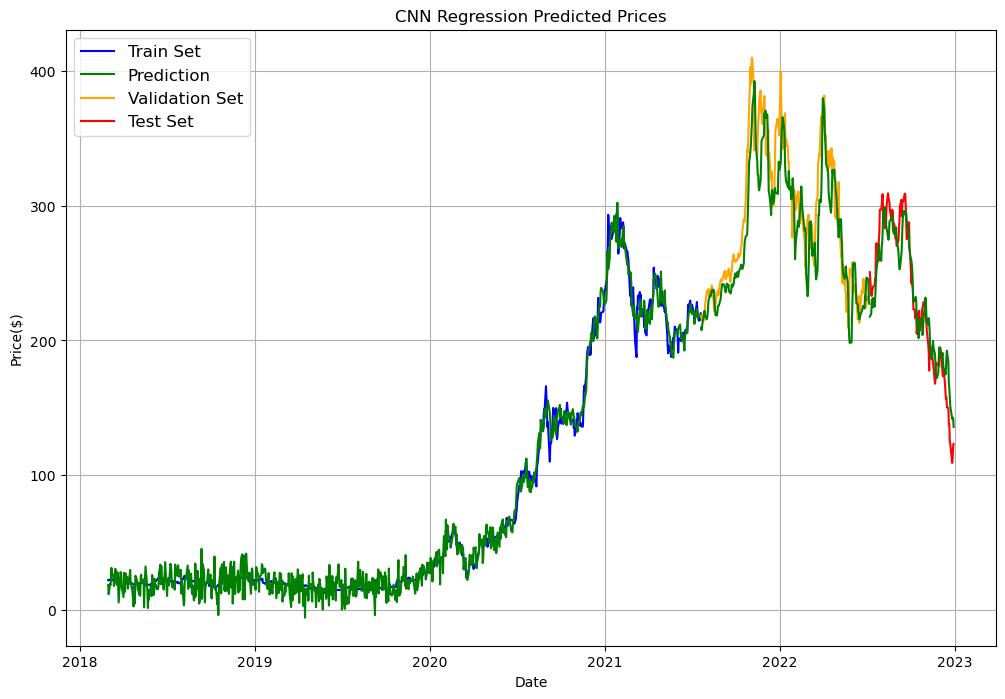

Training completed in 0.64 minutes.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DAYS_FOR_TRAIN = 40  # Time window for training

# Define the CNN-only model
class CNN_Regression(nn.Module):
    def __init__(self, input_size, cnn_filters=64, kernel_size=3, output_size=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters),
            nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters, kernel_size=kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_filters),
            nn.MaxPool1d(kernel_size=2)
        )
        # Fully connected layer for regression output
        self.fc = nn.Linear(cnn_filters * ((DAYS_FOR_TRAIN - 2 * (kernel_size-1)) // 2), output_size)

    def forward(self, x):
        # x: (time_step, batch, feature_dim)
        # Convert to CNN input format: (batch, feature_dim, time_step)
        x = x.permute(1, 2, 0)
        x = self.cnn(x)  # CNN output: (batch, cnn_filters, new_seq_len)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc(x)
        return x

def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x)
        dataset_y.append(close_prices[i + days_for_train])
    return np.array(dataset_x), np.array(dataset_y)

if __name__ == '__main__':
    t0 = time.time()

    # Read CSV file and extract feature columns
    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    # Data normalization
    max_features = np.max(data_features, axis=0)
    min_features = np.min(data_features, axis=0)
    data_features = (data_features - min_features) / (max_features - min_features)

    max_close = np.max(close_prices)
    min_close = np.min(close_prices)
    close_prices = (close_prices - min_close) / (max_close - min_close)

    # Create datasets
    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    train_x = train_x.transpose(1, 0, 2)
    train_y = train_y.reshape(-1, 1)
    val_x = val_x.transpose(1, 0, 2)
    val_y = val_y.reshape(-1)
    test_x = test_x.transpose(1, 0, 2)
    test_y = test_y.reshape(-1)

    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    # Initialize CNN model
    model = CNN_Regression(input_size=5, cnn_filters=64, kernel_size=3, output_size=1)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    # Model training
    for i in range(400):
        model.train()
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 10 == 0:
            print(f'Epoch: {i + 1}, Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).view(-1).data.numpy()
        val_pred = model(val_x).view(-1).data.numpy()
        test_pred = model(test_x).view(-1).data.numpy()

    # De-normalize predictions
    train_pred_real = train_pred * (max_close - min_close) + min_close
    val_pred_real = val_pred * (max_close - min_close) + min_close
    test_pred_real = test_pred * (max_close - min_close) + min_close

    train_y_real = train_y.numpy().flatten() * (max_close - min_close) + min_close
    val_y_real = val_y * (max_close - min_close) + min_close
    test_y_real = test_y * (max_close - min_close) + min_close

    # Convert regression predictions to direction (up/down) predictions
    def get_direction(y):
        return (np.diff(y) > 0).astype(int)

    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    # Calculate classification metrics
    def print_metrics(name, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"{name} Set Metrics:")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
        print(classification_report(y_true, y_pred, zero_division=0))

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    # Visualize results
    plt.figure(figsize=(12, 8))
    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('CNN Regression Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')

# CNN + LSTM
This is our revised hybird model.

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_23479/2495091877.py:79: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


Epoch: 10, Loss: 0.00372
Epoch: 20, Loss: 0.00113
Epoch: 30, Loss: 0.00079
Epoch: 40, Loss: 0.00057
Epoch: 50, Loss: 0.00056
Epoch: 60, Loss: 0.00042
Epoch: 70, Loss: 0.00049
Epoch: 80, Loss: 0.00040
Epoch: 90, Loss: 0.00040
Epoch: 100, Loss: 0.00036
Epoch: 110, Loss: 0.00035
Epoch: 120, Loss: 0.00031
Epoch: 130, Loss: 0.00027
Epoch: 140, Loss: 0.00031
Epoch: 150, Loss: 0.00026
Epoch: 160, Loss: 0.00023
Epoch: 170, Loss: 0.00024
Epoch: 180, Loss: 0.00024
Epoch: 190, Loss: 0.00021
Epoch: 200, Loss: 0.00022
Epoch: 210, Loss: 0.00019
Epoch: 220, Loss: 0.00022
Epoch: 230, Loss: 0.00019
Epoch: 240, Loss: 0.00021
Epoch: 250, Loss: 0.00018
Epoch: 260, Loss: 0.00018
Epoch: 270, Loss: 0.00018
Epoch: 280, Loss: 0.00017
Epoch: 290, Loss: 0.00018
Epoch: 300, Loss: 0.00016
Epoch: 310, Loss: 0.00017
Epoch: 320, Loss: 0.00016
Epoch: 330, Loss: 0.00016
Epoch: 340, Loss: 0.00015
Epoch: 350, Loss: 0.00014
Epoch: 360, Loss: 0.00015
Epoch: 370, Loss: 0.00015
Epoch: 380, Loss: 0.00014
Epoch: 390, Loss: 0.0

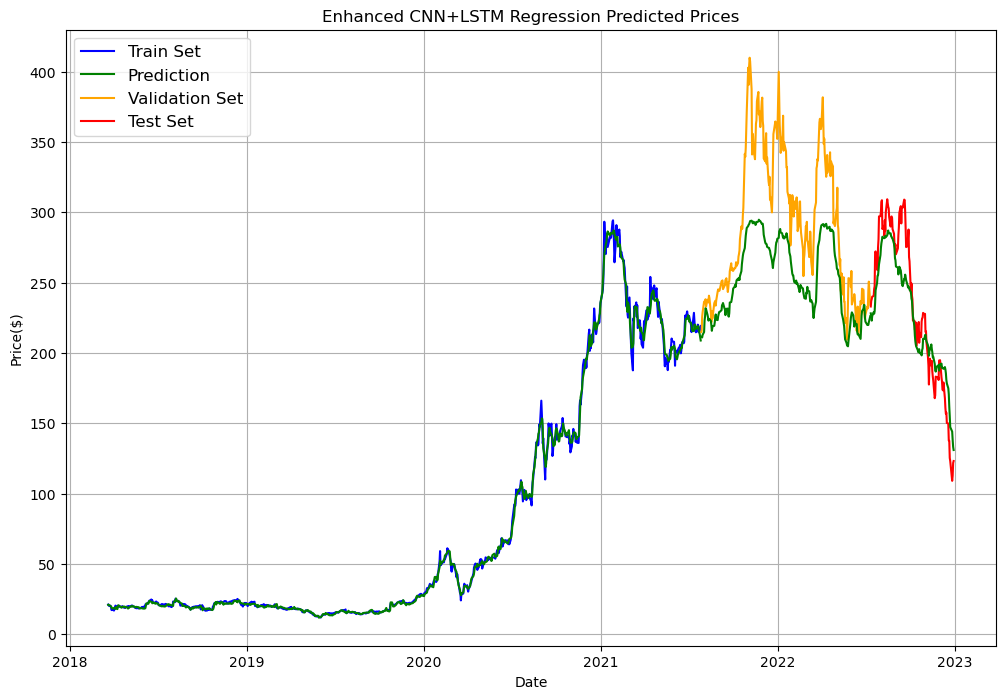

Training completed in 1.14 minutes.


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DAYS_FOR_TRAIN = 40 

def compute_RSI(series, window=14):
    delta = series.diff().dropna()
    up = delta.where(delta > 0, 0.0)
    down = -delta.where(delta < 0, 0.0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean()
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x)
        dataset_y.append(close_prices[i + days_for_train])
    return np.array(dataset_x), np.array(dataset_y)

class Enhanced_CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=1, cnn_filters=64):
        super().__init__()
        # different kernel_size
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_filters, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters, kernel_size=3),
            nn.ReLU()
        )
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_filters, kernel_size=5),
            nn.ReLU()
        )

        self.bn = nn.BatchNorm1d(cnn_filters * 2)
        
        # LSTM
        self.lstm = nn.LSTM(cnn_filters * 2, hidden_size, num_layers=2, batch_first=False, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (time_step, batch, feature_dim)
        x = x.permute(1,2,0)  # (batch, feature_dim, seq_len)
        out1 = self.branch1(x) # (batch, cnn_filters, seq_len-4)
        out2 = self.branch2(x) # (batch, cnn_filters, seq_len-4) [长度根据kernel不同会稍有变化]


        min_len = min(out1.shape[2], out2.shape[2])
        out1 = out1[:, :, :min_len]
        out2 = out2[:, :, :min_len]

        out = torch.cat([out1, out2], dim=1)  # (batch, 2*cnn_filters, seq_len_x)
        out = self.bn(out)

        # back to LSTM (seq_len, batch, features)
        out = out.permute(2, 0, 1)
        out, _ = self.lstm(out)
        out = out[-1,:,:]  
        out = self.fc(out)
        return out

if __name__ == '__main__':
    t0 = time.time()

    data = pd.read_csv('tsla_history.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.sort_values('Date', inplace=True)
    data.reset_index(drop=True, inplace=True)

    data['Return'] = data['Close'].pct_change()
    data['MA5'] = data['Close'].rolling(5).mean()
    data['MA10'] = data['Close'].rolling(10).mean()
    data['RSI'] = compute_RSI(data['Close'], window=14)

    data.dropna(inplace=True)

    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA5', 'MA10', 'RSI']
    data_features = data[features].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    max_features = np.max(data_features, axis=0)
    min_features = np.min(data_features, axis=0)
    data_features = (data_features - min_features) / (max_features - min_features)

    max_close = np.max(close_prices)
    min_close = np.min(close_prices)
    close_prices = (close_prices - min_close) / (max_close - min_close)

    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    dates = data['Date'].values
    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    train_x = train_x.transpose(1, 0, 2)
    train_y = train_y.reshape(-1, 1)
    val_x = val_x.transpose(1, 0, 2)
    val_y = val_y.reshape(-1)
    test_x = test_x.transpose(1, 0, 2)
    test_y = test_y.reshape(-1)

    train_x = torch.from_numpy(train_x).float()
    train_y = torch.from_numpy(train_y).float()
    val_x = torch.from_numpy(val_x).float()
    test_x = torch.from_numpy(test_x).float()

    model = Enhanced_CNN_LSTM(input_size=len(features), hidden_size=32, output_size=1, cnn_filters=64)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i in range(400):
        model.train()
        out = model(train_x)
        loss = loss_function(out, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 10 == 0:
            print(f'Epoch: {i + 1}, Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).view(-1).data.numpy()
        val_pred = model(val_x).view(-1).data.numpy()
        test_pred = model(test_x).view(-1).data.numpy()

    train_pred_real = train_pred * (max_close - min_close) + min_close
    val_pred_real = val_pred * (max_close - min_close) + min_close
    test_pred_real = test_pred * (max_close - min_close) + min_close

    train_y_real = train_y.numpy().flatten() * (max_close - min_close) + min_close
    val_y_real = val_y * (max_close - min_close) + min_close
    test_y_real = test_y * (max_close - min_close) + min_close

    def get_direction(y):
        return (np.diff(y) > 0).astype(int)

    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    def print_metrics(name, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"{name} Set Metrics:")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
        print(classification_report(y_true, y_pred, zero_division=0))

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    plt.figure(figsize=(12, 8))
    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('Enhanced CNN+LSTM Regression Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')


# Baseline Comparison
- This is SVM based regression.

Train Set Metrics:
Accuracy: 0.5200, Precision: 0.5320, Recall: 0.5864, F1-Score: 0.5578
              precision    recall  f1-score   support

           0       0.50      0.45      0.47       412
           1       0.53      0.59      0.56       440

    accuracy                           0.52       852
   macro avg       0.52      0.52      0.52       852
weighted avg       0.52      0.52      0.52       852

Validation Set Metrics:
Accuracy: 0.4711, Precision: 0.5167, Recall: 0.4697, F1-Score: 0.4921
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       110
           1       0.52      0.47      0.49       132

    accuracy                           0.47       242
   macro avg       0.47      0.47      0.47       242
weighted avg       0.48      0.47      0.47       242

Test Set Metrics:
Accuracy: 0.5492, Precision: 0.5400, Recall: 0.4576, F1-Score: 0.4954
              precision    recall  f1-score   support

           0       0

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_26577/3892791818.py:38: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])


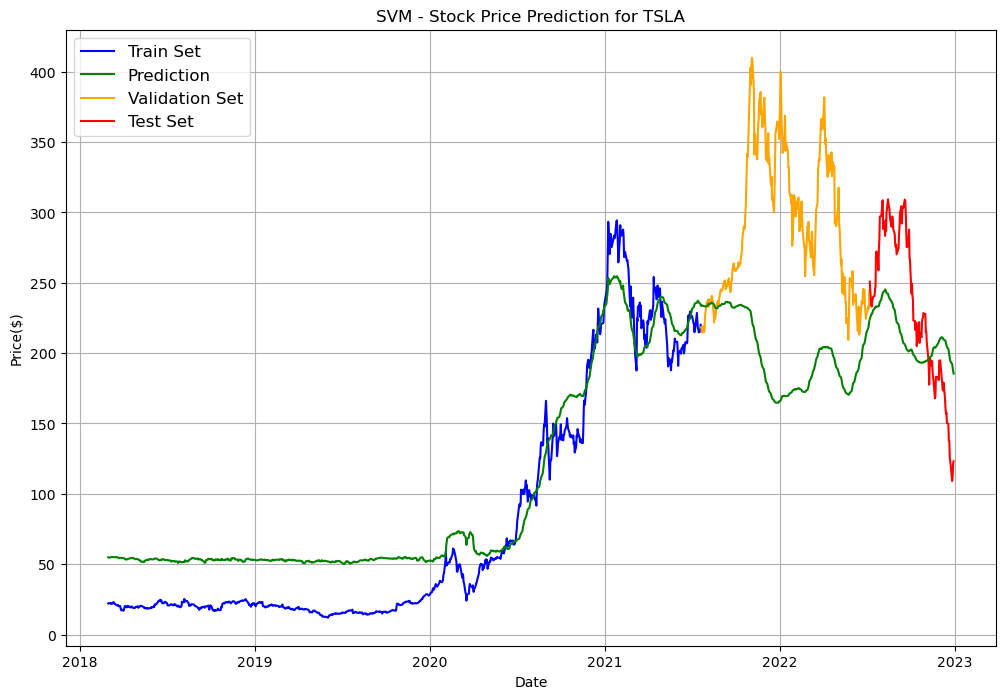

Training completed in 0.00 minutes.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time

DAYS_FOR_TRAIN = 40


def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
       
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x.flatten())
        dataset_y.append(close_prices[i + days_for_train])  
    return np.array(dataset_x), np.array(dataset_y)

def get_direction(y):
    return (np.diff(y) > 0).astype(int)  


def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name} Set Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

if __name__ == '__main__':
    t0 = time.time()

    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])  
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values


    scaler_features = MinMaxScaler()
    data_features = scaler_features.fit_transform(data_features)

    scaler_close = MinMaxScaler()
    close_prices = scaler_close.fit_transform(close_prices.reshape(-1, 1)).flatten()


    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)


    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]


    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    model = SVR(kernel='rbf', C=100, gamma=0.1)
    model.fit(train_x, train_y)

    train_pred = model.predict(train_x)
    val_pred = model.predict(val_x)
    test_pred = model.predict(test_x)

    train_pred_real = scaler_close.inverse_transform(train_pred.reshape(-1, 1)).flatten()
    train_y_real = scaler_close.inverse_transform(train_y.reshape(-1, 1)).flatten()
    val_pred_real = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).flatten()
    val_y_real = scaler_close.inverse_transform(val_y.reshape(-1, 1)).flatten()
    test_pred_real = scaler_close.inverse_transform(test_pred.reshape(-1, 1)).flatten()
    test_y_real = scaler_close.inverse_transform(test_y.reshape(-1, 1)).flatten()

    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    plt.figure(figsize=(12, 8))

    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('SVM - Stock Price Prediction for TSLA')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()

    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')

# Baseline Comparison
- This part is about random forest.

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_26577/3731681048.py:41: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])  # 提取第一列作为日期并转换为datetime格式


Train Set Metrics:
Accuracy: 0.8251, Precision: 0.8063, Recall: 0.8705, F1-Score: 0.8372
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       412
           1       0.81      0.87      0.84       440

    accuracy                           0.83       852
   macro avg       0.83      0.82      0.82       852
weighted avg       0.83      0.83      0.82       852

Validation Set Metrics:
Accuracy: 0.5289, Precision: 0.5692, Recall: 0.5606, F1-Score: 0.5649
              precision    recall  f1-score   support

           0       0.48      0.49      0.49       110
           1       0.57      0.56      0.56       132

    accuracy                           0.53       242
   macro avg       0.53      0.53      0.53       242
weighted avg       0.53      0.53      0.53       242

Test Set Metrics:
Accuracy: 0.5574, Precision: 0.5455, Recall: 0.5085, F1-Score: 0.5263
              precision    recall  f1-score   support

           0       0

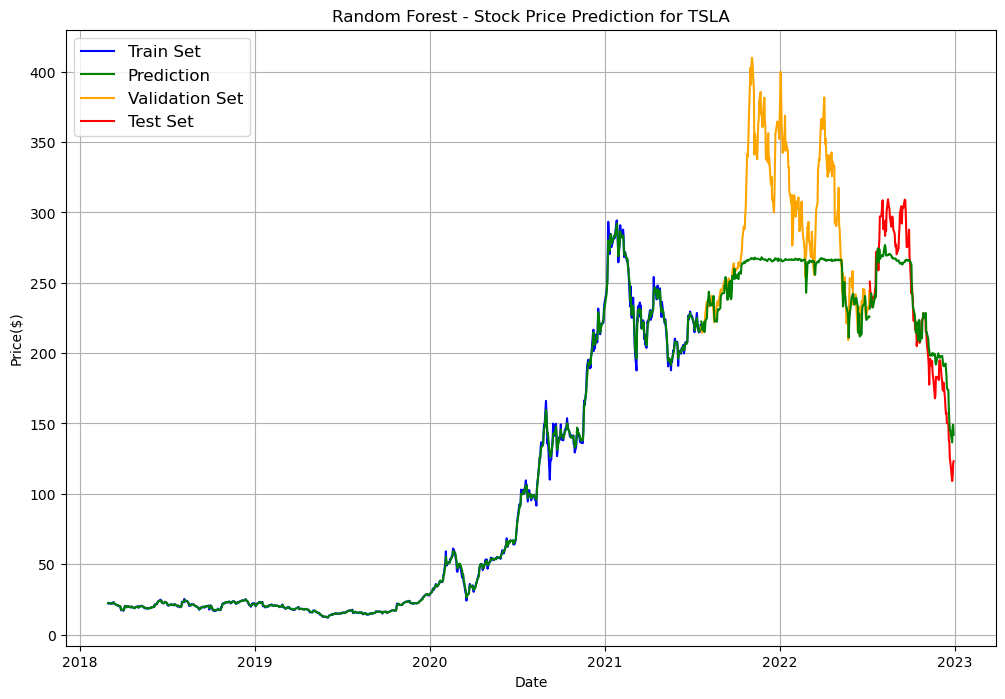

Training completed in 0.07 minutes.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time

DAYS_FOR_TRAIN = 40  # 用于训练的时间窗口

# 创建数据集
def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):
        # 取时间窗口内的多特征数据
        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x.flatten())  # 展平为一维数组
        dataset_y.append(close_prices[i + days_for_train])  # 收盘价作为目标值
    return np.array(dataset_x), np.array(dataset_y)

# 方向预测函数
def get_direction(y):
    return (np.diff(y) > 0).astype(int)  # 涨为1，跌为0

# 打印分类指标
def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name} Set Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

# 主程序
if __name__ == '__main__':
    t0 = time.time()

    # 读取CSV文件并提取特征列
    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])  # 提取第一列作为日期并转换为datetime格式
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    # 数据归一化
    scaler_features = MinMaxScaler()
    data_features = scaler_features.fit_transform(data_features)

    scaler_close = MinMaxScaler()
    close_prices = scaler_close.fit_transform(close_prices.reshape(-1, 1)).flatten()

    # 创建数据集
    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    # 数据划分
    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    # 日期划分
    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(train_x, train_y)


    train_pred = model.predict(train_x)
    val_pred = model.predict(val_x)
    test_pred = model.predict(test_x)


    train_pred_real = scaler_close.inverse_transform(train_pred.reshape(-1, 1)).flatten()
    train_y_real = scaler_close.inverse_transform(train_y.reshape(-1, 1)).flatten()
    val_pred_real = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).flatten()
    val_y_real = scaler_close.inverse_transform(val_y.reshape(-1, 1)).flatten()
    test_pred_real = scaler_close.inverse_transform(test_pred.reshape(-1, 1)).flatten()
    test_y_real = scaler_close.inverse_transform(test_y.reshape(-1, 1)).flatten()


    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)

    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)


    plt.figure(figsize=(12, 8))

    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('Random Forest - Stock Price Prediction for TSLA')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()

    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')

# Baseline Comparison
- This part is about MLP.

Train Set Metrics:
Accuracy: 0.5129, Precision: 0.5291, Recall: 0.5159, F1-Score: 0.5224
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       412
           1       0.53      0.52      0.52       440

    accuracy                           0.51       852
   macro avg       0.51      0.51      0.51       852
weighted avg       0.51      0.51      0.51       852

Validation Set Metrics:
Accuracy: 0.4835, Precision: 0.5276, Recall: 0.5076, F1-Score: 0.5174
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       110
           1       0.53      0.51      0.52       132

    accuracy                           0.48       242
   macro avg       0.48      0.48      0.48       242
weighted avg       0.49      0.48      0.48       242

Test Set Metrics:
Accuracy: 0.5082, Precision: 0.4912, Recall: 0.4746, F1-Score: 0.4828
              precision    recall  f1-score   support

           0       0

/var/folders/3y/x421s16x34d9kn8n_1176wmw0000gn/T/ipykernel_26577/1838686548.py:37: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  dates = pd.to_datetime(data.iloc[:, 0])


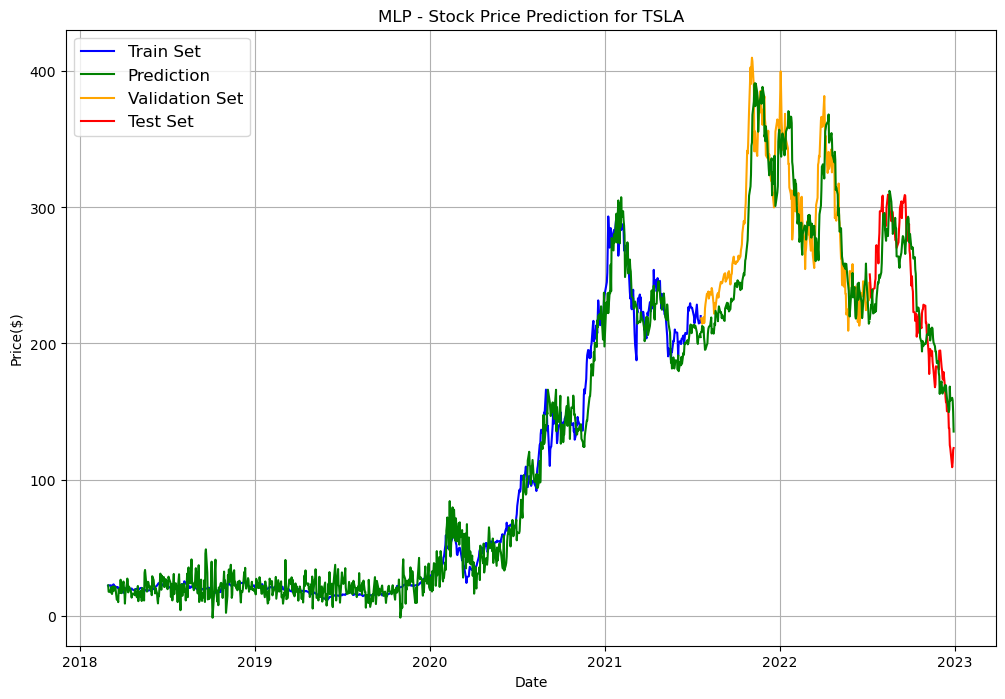

Training completed in 0.00 minutes.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time

DAYS_FOR_TRAIN = 40

def create_dataset(data, close_prices, days_for_train):
    dataset_x, dataset_y = [], []
    for i in range(len(data) - days_for_train):

        _x = data[i:(i + days_for_train), :]
        dataset_x.append(_x.flatten())  
        dataset_y.append(close_prices[i + days_for_train]) 
    return np.array(dataset_x), np.array(dataset_y)


def get_direction(y):
    return (np.diff(y) > 0).astype(int)  

def print_metrics(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name} Set Metrics:")
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

if __name__ == '__main__':
    t0 = time.time()

    data = pd.read_csv('tsla_history.csv')
    dates = pd.to_datetime(data.iloc[:, 0])  
    data_features = data[['Close', 'Open', 'High', 'Low', 'Volume']].astype('float32').values
    close_prices = data['Close'].astype('float32').values

    scaler_features = MinMaxScaler()
    data_features = scaler_features.fit_transform(data_features)

    scaler_close = MinMaxScaler()
    close_prices = scaler_close.fit_transform(close_prices.reshape(-1, 1)).flatten()

    dataset_x, dataset_y = create_dataset(data_features, close_prices, DAYS_FOR_TRAIN)
    total_size = len(dataset_x)
    train_size = int(total_size * 0.7)
    val_size = int(total_size * 0.2)

    train_x = dataset_x[:train_size]
    train_y = dataset_y[:train_size]
    val_x = dataset_x[train_size:train_size + val_size]
    val_y = dataset_y[train_size:train_size + val_size]
    test_x = dataset_x[train_size + val_size:]
    test_y = dataset_y[train_size + val_size:]

    train_dates = dates[DAYS_FOR_TRAIN:train_size + DAYS_FOR_TRAIN]
    val_dates = dates[train_size + DAYS_FOR_TRAIN:train_size + val_size + DAYS_FOR_TRAIN]
    test_dates = dates[train_size + val_size + DAYS_FOR_TRAIN:]

    # MLP INIT
    model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    model.fit(train_x, train_y)


    train_pred = model.predict(train_x)
    val_pred = model.predict(val_x)
    test_pred = model.predict(test_x)

    train_pred_real = scaler_close.inverse_transform(train_pred.reshape(-1, 1)).flatten()
    train_y_real = scaler_close.inverse_transform(train_y.reshape(-1, 1)).flatten()
    val_pred_real = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).flatten()
    val_y_real = scaler_close.inverse_transform(val_y.reshape(-1, 1)).flatten()
    test_pred_real = scaler_close.inverse_transform(test_pred.reshape(-1, 1)).flatten()
    test_y_real = scaler_close.inverse_transform(test_y.reshape(-1, 1)).flatten()


    train_true_dir = get_direction(train_y_real)
    train_pred_dir = get_direction(train_pred_real)

    val_true_dir = get_direction(val_y_real)
    val_pred_dir = get_direction(val_pred_real)

    test_true_dir = get_direction(test_y_real)
    test_pred_dir = get_direction(test_pred_real)


    print_metrics("Train", train_true_dir, train_pred_dir)
    print_metrics("Validation", val_true_dir, val_pred_dir)
    print_metrics("Test", test_true_dir, test_pred_dir)

    plt.figure(figsize=(12, 8))

    plt.plot(train_dates, train_y_real, label='Train Set', color='blue')
    plt.plot(train_dates, train_pred_real, label='Prediction', color='green')

    plt.plot(val_dates, val_y_real, label='Validation Set', color='orange')
    plt.plot(val_dates, val_pred_real, color='green')

    plt.plot(test_dates, test_y_real, label='Test Set', color='red')
    plt.plot(test_dates, test_pred_real, color='green')

    plt.title('MLP - Stock Price Prediction for TSLA')
    plt.xlabel('Date')
    plt.ylabel('Price($)')
    plt.legend(fontsize=12)
    plt.grid()

    plt.show()

    t1 = time.time()
    print(f'Training completed in {(t1 - t0) / 60:.2f} minutes.')